In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import glob
import numpy as np
import pandas as pd 
import nibabel as nib
from nilearn.input_data import NiftiMasker
from matplotlib import pyplot as plt
import seaborn as sns

from itertools import combinations_with_replacement, product

sys.path.append('../utils/') 

from config import *
import dataset_utils as utils
from tommy_utils import statistics, plotting, encoding, nlp
from timepoint_classification import run_searchlight_timepoint_classification

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Select dataset to analyze

In [2]:
dataset = 'deniz-readinglistening'

results_dir = os.path.join(BASE_DIR, 'derivatives/results/', dataset) #, p.sub, p.model_name)
plots_dir = os.path.join(BASE_DIR, 'derivatives/plots/isc/', dataset, 'group')

utils.attempt_makedirs(plots_dir)

if dataset == 'deniz-readinglistening':
    data_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/dark-matter-preproc/')
else:
    data_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/dark-matter-preproc-smooth/')
    masks_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/masks/group/')
    mask_fn = os.path.join(masks_dir, 'group-MNI152NLin6Asym_res-all_desc-brain_gm-mask-intersection.nii.gz')
    masker = NiftiMasker(mask_fn).fit()

## Load data for a given participant

In [3]:
# get subjects excluding their html files
sub_dirs = sorted(glob.glob(os.path.join(data_dir, 'sub*[!html]')))
sub_list = [os.path.basename(d) for d in sub_dirs]

task_list = utils.DATASETS[dataset]['tasks']

In [4]:
sessions = ['reading', 'listening']

all_data = utils.make_nested_dictionary()

for session, task in product(sessions, task_list):
    all_sub_data = []
    
    for sub in sub_list:
        sub_data_fn = sorted(glob.glob(os.path.join(data_dir, sub, f'*{session}*{task}*hyperaligned.npy')))

        # only load the first file
        all_sub_data.append(np.load(sub_data_fn[0]))
        print (f'Loaded {sub} - {session}, {task}')
        
    all_data[session][task] = np.stack(all_sub_data)

Loaded sub-01 - reading, alternateithicatom
Loaded sub-02 - reading, alternateithicatom
Loaded sub-03 - reading, alternateithicatom
Loaded sub-04 - reading, alternateithicatom
Loaded sub-05 - reading, alternateithicatom
Loaded sub-06 - reading, alternateithicatom
Loaded sub-07 - reading, alternateithicatom
Loaded sub-08 - reading, alternateithicatom
Loaded sub-09 - reading, alternateithicatom
Loaded sub-01 - reading, avatar
Loaded sub-02 - reading, avatar
Loaded sub-03 - reading, avatar
Loaded sub-04 - reading, avatar
Loaded sub-05 - reading, avatar
Loaded sub-06 - reading, avatar
Loaded sub-07 - reading, avatar
Loaded sub-08 - reading, avatar
Loaded sub-09 - reading, avatar
Loaded sub-01 - reading, legacy
Loaded sub-02 - reading, legacy
Loaded sub-03 - reading, legacy
Loaded sub-04 - reading, legacy
Loaded sub-05 - reading, legacy
Loaded sub-06 - reading, legacy
Loaded sub-07 - reading, legacy
Loaded sub-08 - reading, legacy
Loaded sub-09 - reading, legacy
Loaded sub-01 - reading, ode

## Conduct ISC both within and across session types

In [5]:
def ztransform_mean(dss):
    return np.tanh(np.mean([np.arctanh(ds) for ds in dss], axis=0))

In [19]:
ses_comparison_isc = utils.make_nested_dictionary()

sub_idxs = np.arange(len(sub_list))

# train on one session type, test on either same or difference session type
for ses_train, ses_test in product(sessions, repeat=2):
    for task in task_list:

        all_comparison_isc = []
    
        for train_idx, sub in enumerate(sub_list):
            print (f'{ses_train} - {ses_test}: {sub}')
            
            # test idxs are all subjects except the current one
            test_idxs = list(set(sub_idxs).difference([train_idx]))
    
            ds_train = all_data[ses_train][task][train_idx] # get the train subject
            ds_test = all_data[ses_test][task][test_idxs].mean(0) # average the group
    
            isc = statistics.array_correlation(ds_train, ds_test)
            all_comparison_isc.append(isc)

        ses_comparison_isc[f'{ses_train}-{ses_test}'][task] = np.stack(all_comparison_isc)

reading - reading: sub-01
reading - reading: sub-02


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/tommy_utils/statistics.py:72: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


reading - reading: sub-03
reading - reading: sub-04
reading - reading: sub-05
reading - reading: sub-06
reading - reading: sub-07
reading - reading: sub-08
reading - reading: sub-09
reading - reading: sub-01
reading - reading: sub-02
reading - reading: sub-03
reading - reading: sub-04
reading - reading: sub-05
reading - reading: sub-06
reading - reading: sub-07
reading - reading: sub-08
reading - reading: sub-09
reading - reading: sub-01
reading - reading: sub-02
reading - reading: sub-03
reading - reading: sub-04
reading - reading: sub-05
reading - reading: sub-06
reading - reading: sub-07
reading - reading: sub-08
reading - reading: sub-09
reading - reading: sub-01


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


reading - reading: sub-02
reading - reading: sub-03
reading - reading: sub-04
reading - reading: sub-05
reading - reading: sub-06
reading - reading: sub-07
reading - reading: sub-08
reading - reading: sub-09
reading - reading: sub-01
reading - reading: sub-02
reading - reading: sub-03
reading - reading: sub-04
reading - reading: sub-05
reading - reading: sub-06
reading - reading: sub-07
reading - reading: sub-08
reading - reading: sub-09
reading - reading: sub-01
reading - reading: sub-02
reading - reading: sub-03
reading - reading: sub-04
reading - reading: sub-05
reading - reading: sub-06
reading - reading: sub-07
reading - reading: sub-08
reading - reading: sub-09
reading - reading: sub-01
reading - reading: sub-02
reading - reading: sub-03
reading - reading: sub-04
reading - reading: sub-05
reading - reading: sub-06
reading - reading: sub-07
reading - reading: sub-08
reading - reading: sub-09
reading - reading: sub-01
reading - reading: sub-02
reading - reading: sub-03
reading - re

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/tommy_utils/statistics.py:66: RuntimeWarning: invalid value encountered in multiply
  numerator = np.sum(x_demean * y_demean, axis=0)
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/tommy_utils/statistics.py:69: RuntimeWarning: invalid value encountered in multiply
  denominator = np.sqrt(np.sum(x_demean ** 2, axis=0) *


reading - listening: sub-02
reading - listening: sub-03
reading - listening: sub-04
reading - listening: sub-05
reading - listening: sub-06
reading - listening: sub-07
reading - listening: sub-08
reading - listening: sub-09
reading - listening: sub-01
reading - listening: sub-02
reading - listening: sub-03
reading - listening: sub-04
reading - listening: sub-05
reading - listening: sub-06
reading - listening: sub-07
reading - listening: sub-08
reading - listening: sub-09
reading - listening: sub-01
reading - listening: sub-02
reading - listening: sub-03
reading - listening: sub-04
reading - listening: sub-05
reading - listening: sub-06
reading - listening: sub-07
reading - listening: sub-08
reading - listening: sub-09
reading - listening: sub-01
reading - listening: sub-02
reading - listening: sub-03
reading - listening: sub-04
reading - listening: sub-05
reading - listening: sub-06
reading - listening: sub-07
reading - listening: sub-08
reading - listening: sub-09
reading - listening:

## Plot the ISC comparisons averaged across tasks

In [20]:
all_avgs = {}
cmap = 'RdBu_r'

for ses, ses_results in ses_comparison_isc.items():
    ds_results = np.stack([results for task, results in ses_results.items()])
    ds_sub_avg = ztransform_mean(ds_results)

    all_avgs[ses] = ds_sub_avg

vmax = np.nanmax([np.nanmax(abs(ztransform_mean(results))) for _, results in all_avgs.items()])

for comparison, results in all_avgs.items():
    
    # average isc across participants
    ds_avg = ztransform_mean(results)

    out_fn = os.path.join(plots_dir, f'group_{comparison}_all-tasks_loo-isc.{EXT}')
    
    if TITLE:
        title = f'{comparison} - LOO ISC'
    else:
        title = '' 
    
    if dataset == 'deniz-readinglistening':
        surfs, data = plotting.numpy_to_surface(ds_avg, target_density='41k')
    else:
        ds_signif = masker.inverse_transform(sig_counts)
        surfs, data = plotting.vol_to_surf(ds_signif, surf_type='fsaverage', map_type='inflated', method='nearest')
    
    layer = plotting.make_layers_dict(data=data, cmap=cmap, label=f'ISC (r)', alpha=1, color_range=(-vmax, vmax))
    
    _ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
        add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

Here
Here
Here
Here


### Plot ISC results for each task

In [81]:
cmap = 'RdBu_r'

vmax = np.nanmax([np.nanmax(abs(ztransform_mean(results))) for _, results in ses_comparison_isc.items()])

for comparison, results in ses_comparison_isc.items():
    
    # average isc across participants
    ds_avg = ztransform_mean(results)
    
    out_fn = os.path.join(plots_dir, f'group_{comparison}_task-{task}_loo-isc.{EXT}')
    
    if TITLE:
        title = f'{comparison} - LOO ISC'
    else:
        title = '' 
    
    if dataset == 'deniz-readinglistening':
        surfs, data = plotting.numpy_to_surface(ds_avg, target_density='41k')
    else:
        ds_signif = masker.inverse_transform(sig_counts)
        surfs, data = plotting.vol_to_surf(ds_signif, surf_type='fsaverage', map_type='inflated', method='nearest')
    
    layer = plotting.make_layers_dict(data=data, cmap=cmap, label=f'ISC (r)', alpha=1, color_range=(-vmax, vmax))
    
    _ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
        add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

Here
Here
Here


## Contrast listening - reading ISC

In [37]:
ds_reading = ses_comparison_isc['reading-reading']
ds_listening = ses_comparison_isc['listening-listening']


In [34]:
dss_contrast = []

for task in task_list:
    ds_contrast = np.arctanh(ds_listening[task]) - np.arctanh(ds_reading[task])
    dss_contrast.append(ds_contrast)

dss_contrast = ztransform_mean(dss_contrast)

/scratch/ipykernel_153847/2599855014.py:2: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(np.mean([np.arctanh(ds) for ds in dss], axis=0))


In [36]:
# ds_reading = ses_comparison_isc['reading-reading']
# ds_listening = ses_comparison_isc['listening-listening']

# # contrast reading vs listening
# ds_contrast = np.arctanh(ds_listening) - np.arctanh(ds_reading)
ds_contrast = ztransform_mean(dss_contrast)

vmax = np.nanmax(abs(dss_contrast))

out_fn = os.path.join(plots_dir, f'group_listening-reading-contrast_all-tasks_loo-isc.{EXT}')

if dataset == 'deniz-readinglistening':
    surfs, data = plotting.numpy_to_surface(ds_contrast, target_density='41k')
    
layer = plotting.make_layers_dict(data=data, cmap=cmap, label=f'ISC (r) - pos=listening', alpha=1, color_range=(-vmax, vmax))

_ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
    add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

Here


## Timepoint classification

### Load and plot timepoint classification results

In [4]:
sessions = ['reading', 'listening']

classification_accuracy = utils.make_nested_dictionary()

sub_idxs = np.arange(len(sub_list))

# train on one session type, test on either same or difference session type
for train_session, test_session in product(sessions, repeat=2):
    
    dss_accuracy = []
    
    for task in task_list[:-1]:
        
        task_accuracy = []

        for sub in sub_list:
            print (f'{train_session} // {test_session} // {task} // {sub}')

            # try:
            results_fn = glob.glob(os.path.join(results_dir, sub, 'timepoint_classification', f'*{task}*train-{train_session}*test-{test_session}*'))

            assert (len(results_fn) == 1)

            ds_results = np.load(results_fn[0])
            task_accuracy.append(ds_results)
        # except:
        #     pass
        
        task_accuracy = np.stack(task_accuracy)
        # dss_accuracy.append(task_accuracy)
        classification_accuracy[f'{train_session}-{test_session}'][task] = task_accuracy

reading // reading // alternateithicatom // sub-01
reading // reading // alternateithicatom // sub-02
reading // reading // alternateithicatom // sub-03
reading // reading // alternateithicatom // sub-04
reading // reading // alternateithicatom // sub-05
reading // reading // alternateithicatom // sub-06
reading // reading // alternateithicatom // sub-07
reading // reading // alternateithicatom // sub-08
reading // reading // alternateithicatom // sub-09
reading // reading // avatar // sub-01
reading // reading // avatar // sub-02
reading // reading // avatar // sub-03
reading // reading // avatar // sub-04
reading // reading // avatar // sub-05
reading // reading // avatar // sub-06
reading // reading // avatar // sub-07
reading // reading // avatar // sub-08
reading // reading // avatar // sub-09
reading // reading // legacy // sub-01
reading // reading // legacy // sub-02
reading // reading // legacy // sub-03
reading // reading // legacy // sub-04
reading // reading // legacy // su

### Contrast reading-listening vs. listening-reading

In [57]:
dss_contrast = []

for task in task_list[:-1]:

    print (task)
    
    ds_contrast = classification_accuracy['listening-reading'][task].mean(1) - classification_accuracy['reading-listening'][task].mean(1)
    ds_contrast = ds_contrast.mean(0)
    
    dss_contrast.append(ds_contrast)

dss_contrast = np.stack(dss_contrast)

alternateithicatom
avatar
legacy
odetostepfather
souls
howtodraw
myfirstdaywiththeyankees
naked
undertheinfluence
life


Here


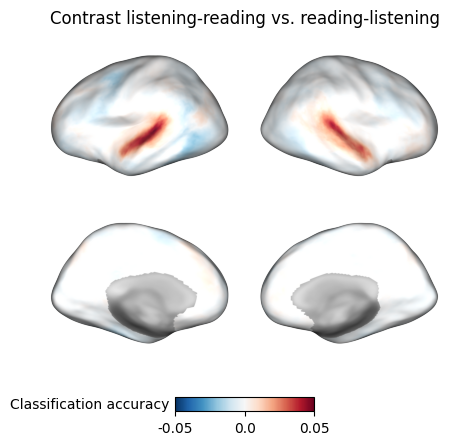

In [60]:
title = f'Contrast listening-reading vs. reading-listening'
label = 'Classification accuracy'

ds_contrast = dss_contrast.mean(0)
cmap = 'RdBu_r'
vmax = np.max(abs(ds_contrast))

if dataset == 'deniz-readinglistening':
    surfs, data = plotting.numpy_to_surface(ds_contrast, target_density='41k')
layer = plotting.make_layers_dict(data=data, cmap=cmap, label=label, alpha=1, color_range=(-vmax, vmax))

_ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
    add_depth=ADD_DEPTH, embed_nb=True, title=title)

Here


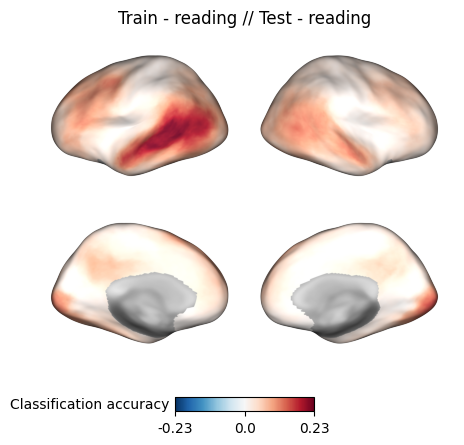

In [444]:
title = f'Train - {train_session} // Test - {test_session}'
label = 'Classification accuracy'

vmax = np.max(abs(ds_avg_accuracy))

if dataset == 'deniz-readinglistening':
    surfs, data = plotting.numpy_to_surface(ds_avg_accuracy, target_density='41k')
    
layer = plotting.make_layers_dict(data=data, cmap=cmap, label=label, alpha=1, color_range=(-vmax, vmax))

_ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
    add_depth=ADD_DEPTH, embed_nb=True, title=title)

### Make plots

### Load language network stuff

In [61]:
from neuromaps.transforms import mni152_to_fsaverage

language_regions = {
    1: "LH_IFGorb",
    2: "LH_IFG",
    3: "LH_MFG",
    4: "LH_AntTemp",
    5: "LH_MidTemp",
    6: "LH_PostTemp",
    7: "RH_IFGorb",
    8: "RH_IFG",
    9: "RH_MFG",
    10: "RH_AntTemp",
    11: "RH_MidTemp",
    12: "RH_PostTemp"
}

atlas_language = nib.load(os.path.join(ATLAS_DIR, 'language_regions/allParcels_language_SN220.nii'))

# map to fsaverage and put hemis together
atlas_language = mni152_to_fsaverage(atlas_language, fsavg_density='10k', method='nearest')
atlas_language = np.concatenate([hemi.agg_data() for hemi in atlas_language])

In [62]:
classification_accuracy

defaultdict(<function dataset_utils.make_nested_dictionary.<locals>.<lambda>()>,
            {'reading-reading': defaultdict(<function dataset_utils.make_nested_dictionary.<locals>.<lambda>()>,
                         {'alternateithicatom': array([[[0., 0., 0., ..., 0., 0., 0.],
                                  [0., 1., 0., ..., 0., 0., 0.],
                                  [0., 1., 0., ..., 0., 0., 0.],
                                  ...,
                                  [0., 0., 0., ..., 0., 0., 0.],
                                  [0., 0., 0., ..., 0., 0., 0.],
                                  [0., 0., 0., ..., 0., 0., 0.]],
                          
                                 [[1., 1., 0., ..., 1., 1., 1.],
                                  [1., 0., 0., ..., 1., 1., 1.],
                                  [1., 0., 0., ..., 0., 0., 0.],
                                  ...,
                                  [0., 0., 1., ..., 1., 1., 1.],
                            

In [67]:
df_stack = []

for idx, region in language_regions.items():
    for ses, ses_accuracy in classification_accuracy.items():
        for task, accuracy in ses_accuracy.items():

            print (f'{region} // {ses} // {task}')
            accuracy = accuracy.mean(1).mean(0)
            region_accuracy = accuracy[atlas_language == idx]
    
            df = pd.DataFrame(region_accuracy, columns=['accuracy'])
            df['region'] = region
            df['ses'] = ses
            df['task'] = task

            df_stack.append(df)

df_stack = pd.concat(df_stack).reset_index(drop=True)

LH_IFGorb // reading-reading // alternateithicatom
LH_IFGorb // reading-reading // avatar
LH_IFGorb // reading-reading // legacy
LH_IFGorb // reading-reading // odetostepfather
LH_IFGorb // reading-reading // souls
LH_IFGorb // reading-reading // howtodraw
LH_IFGorb // reading-reading // myfirstdaywiththeyankees
LH_IFGorb // reading-reading // naked
LH_IFGorb // reading-reading // undertheinfluence
LH_IFGorb // reading-reading // life
LH_IFGorb // reading-listening // alternateithicatom
LH_IFGorb // reading-listening // avatar
LH_IFGorb // reading-listening // legacy
LH_IFGorb // reading-listening // odetostepfather
LH_IFGorb // reading-listening // souls
LH_IFGorb // reading-listening // howtodraw
LH_IFGorb // reading-listening // myfirstdaywiththeyankees
LH_IFGorb // reading-listening // naked
LH_IFGorb // reading-listening // undertheinfluence
LH_IFGorb // reading-listening // life
LH_IFGorb // listening-reading // alternateithicatom
LH_IFGorb // listening-reading // avatar
LH_IFGor

/scratch/ipykernel_127276/2703448001.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g = g.set_xticklabels(g.get_xticklabels(), rotation=45)


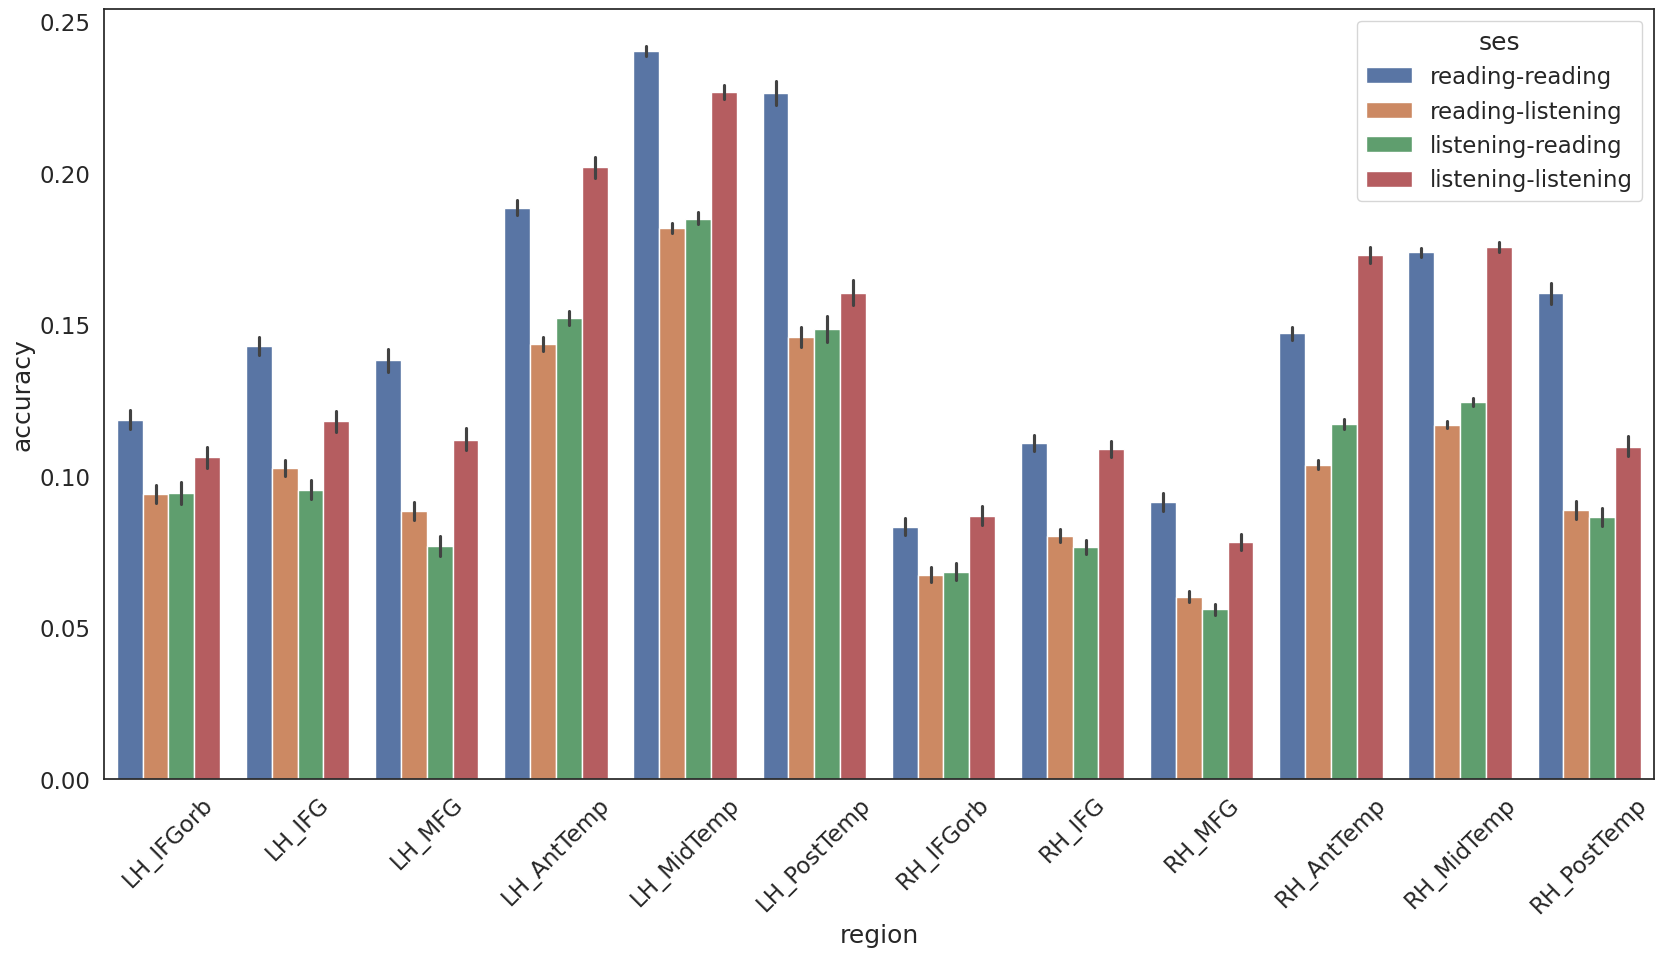

In [72]:
sns.set(style='white', rc={'figure.figsize':(20, 10), "axes.titlesize":18}, font_scale=1.5)

g = sns.barplot(df_stack, x='region', y='accuracy', hue='ses')
g = g.set_xticklabels(g.get_xticklabels(), rotation=45)


### Plot as barplot

<Axes: xlabel='variable', ylabel='value'>

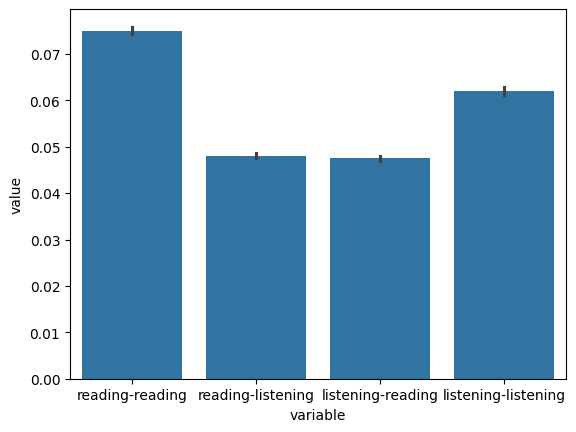

In [465]:
df_accuracy = pd.DataFrame(classification_accuracy)
df_accuracy = pd.melt(df_accuracy)


sns.barplot(df_accuracy, x='variable', y='value')